In [1]:
import pandas as pd
import numpy as np
import  matplotlib.pyplot as  plt
import matplotlib.patches as mpatches
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
from pmdarima.arima import auto_arima
from sklearn import metrics
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

In [2]:
df = pd.read_csv(r'C:\Users\maxim\Documents\GitHub\gold-forecast\data\data_nominal_clean.csv', sep=';',  index_col='date',  parse_dates=['date'])
df.head()

,Gold,CrudeOil,S&P500,FTSE250
date,,,,
1986-01-02,326.30,25.56,209.59,1417.26
1986-01-03,326.75,26.00,210.88,1424.61
1986-01-06,328.00,26.53,210.65,1430.96
1986-01-07,330.00,25.85,213.80,1421.22
1986-01-08,332.60,25.87,207.97,1408.79


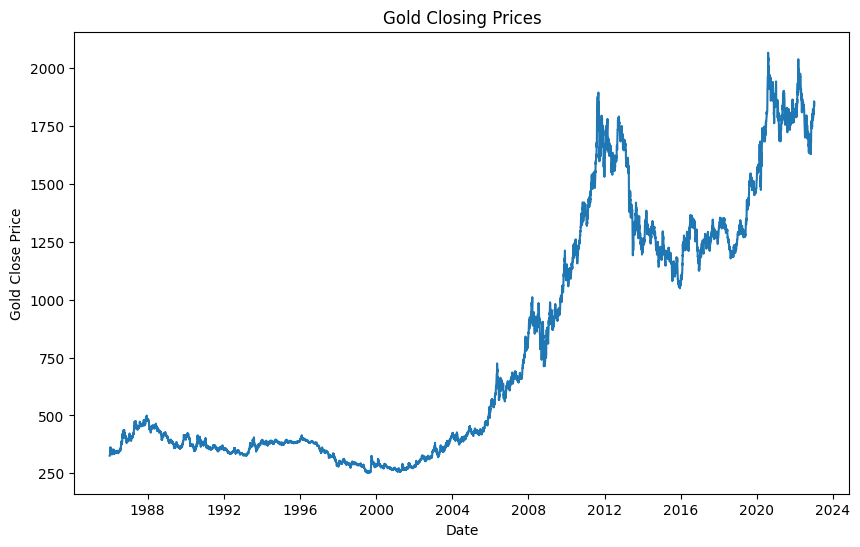

In [3]:
plt.figure(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Gold Close Price')
plt.plot(df['Gold'])
plt.title('Gold Closing Prices')
plt.show()

<AxesSubplot: ylabel='Density'>

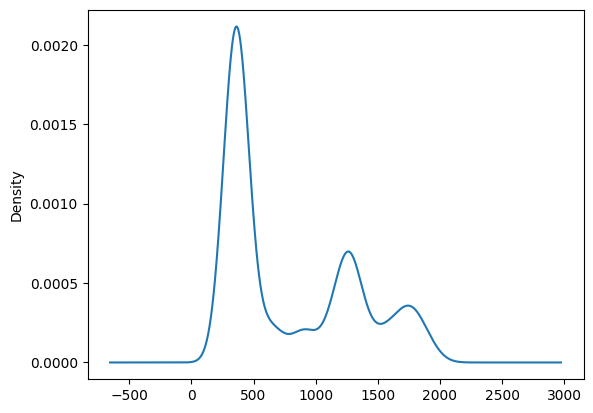

In [4]:
df.Gold.plot(kind='kde')

c:\Users\maxim\Documents\GitHub\gold-forecast\venv\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


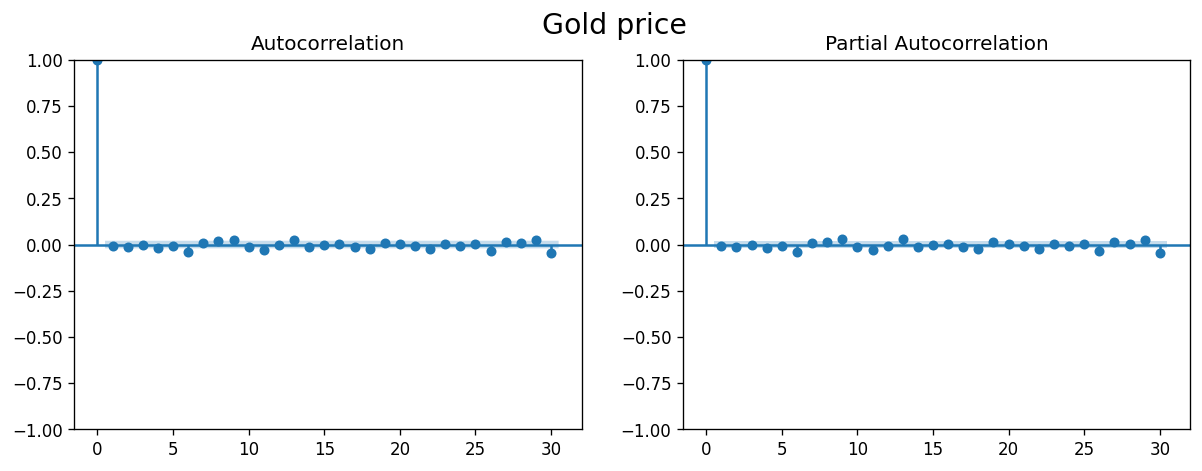

In [5]:
dfac = df.copy()
dfac.reset_index(inplace=True, drop=True)

plt.rcParams.update({'figure.figsize':(12,4), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=False)
fig.suptitle('Gold price', fontsize=17)
plot_acf(dfac['Gold'].diff().dropna(), ax=axes[0], lags=30)
plot_pacf(dfac['Gold'].diff().dropna(), ax=axes[1], lags=30)

plt.show()

In [6]:
testr = adfuller(df.Gold)
testr[0]

0.27536589347060364

In [7]:
def plot_test_stationarity(subplot, timeseries, name):
    
    adf = adfuller(timeseries,autolag='AIC')
    #Determing rolling statistics
    rolmean = timeseries.rolling(30).mean()
    rolstd = timeseries.rolling(30).std()
    #Plot rolling statistics:
    subplot.plot(timeseries, color='blue',label='Original')
    subplot.plot(rolmean, color='red', label='Rolling Mean')
    subplot.plot(rolstd, color='black', label = 'Rolling Std')
    subplot.title.set_text(f'{name}\nADF Results: Test Statistic: {round(adf[0],2)}, p-value: {round(adf[1],2)}')
    
    return plt

In [8]:
def plotall(df):
        blue_patch = mpatches.Patch(color='blue', label='Original')
        red_patch = mpatches.Patch(color='red', label='Rolling Mean')
        black_patch = mpatches.Patch(color='black', label='Rolling Std')

        fig, subplots = plt.subplots(nrows=4, ncols=1, figsize=(12,20))
        fig.suptitle("Rolling Means and Standard Deviations", fontsize=20, x=0.35, y=0.95)
        fig.legend(handles=[red_patch, blue_patch, black_patch], bbox_to_anchor=(0.9,0.95))

        for cname, subplot in zip(df.columns,subplots):
                plot_test_stationarity(subplot, df[cname], cname)

        plt.show()
        plt.clf()

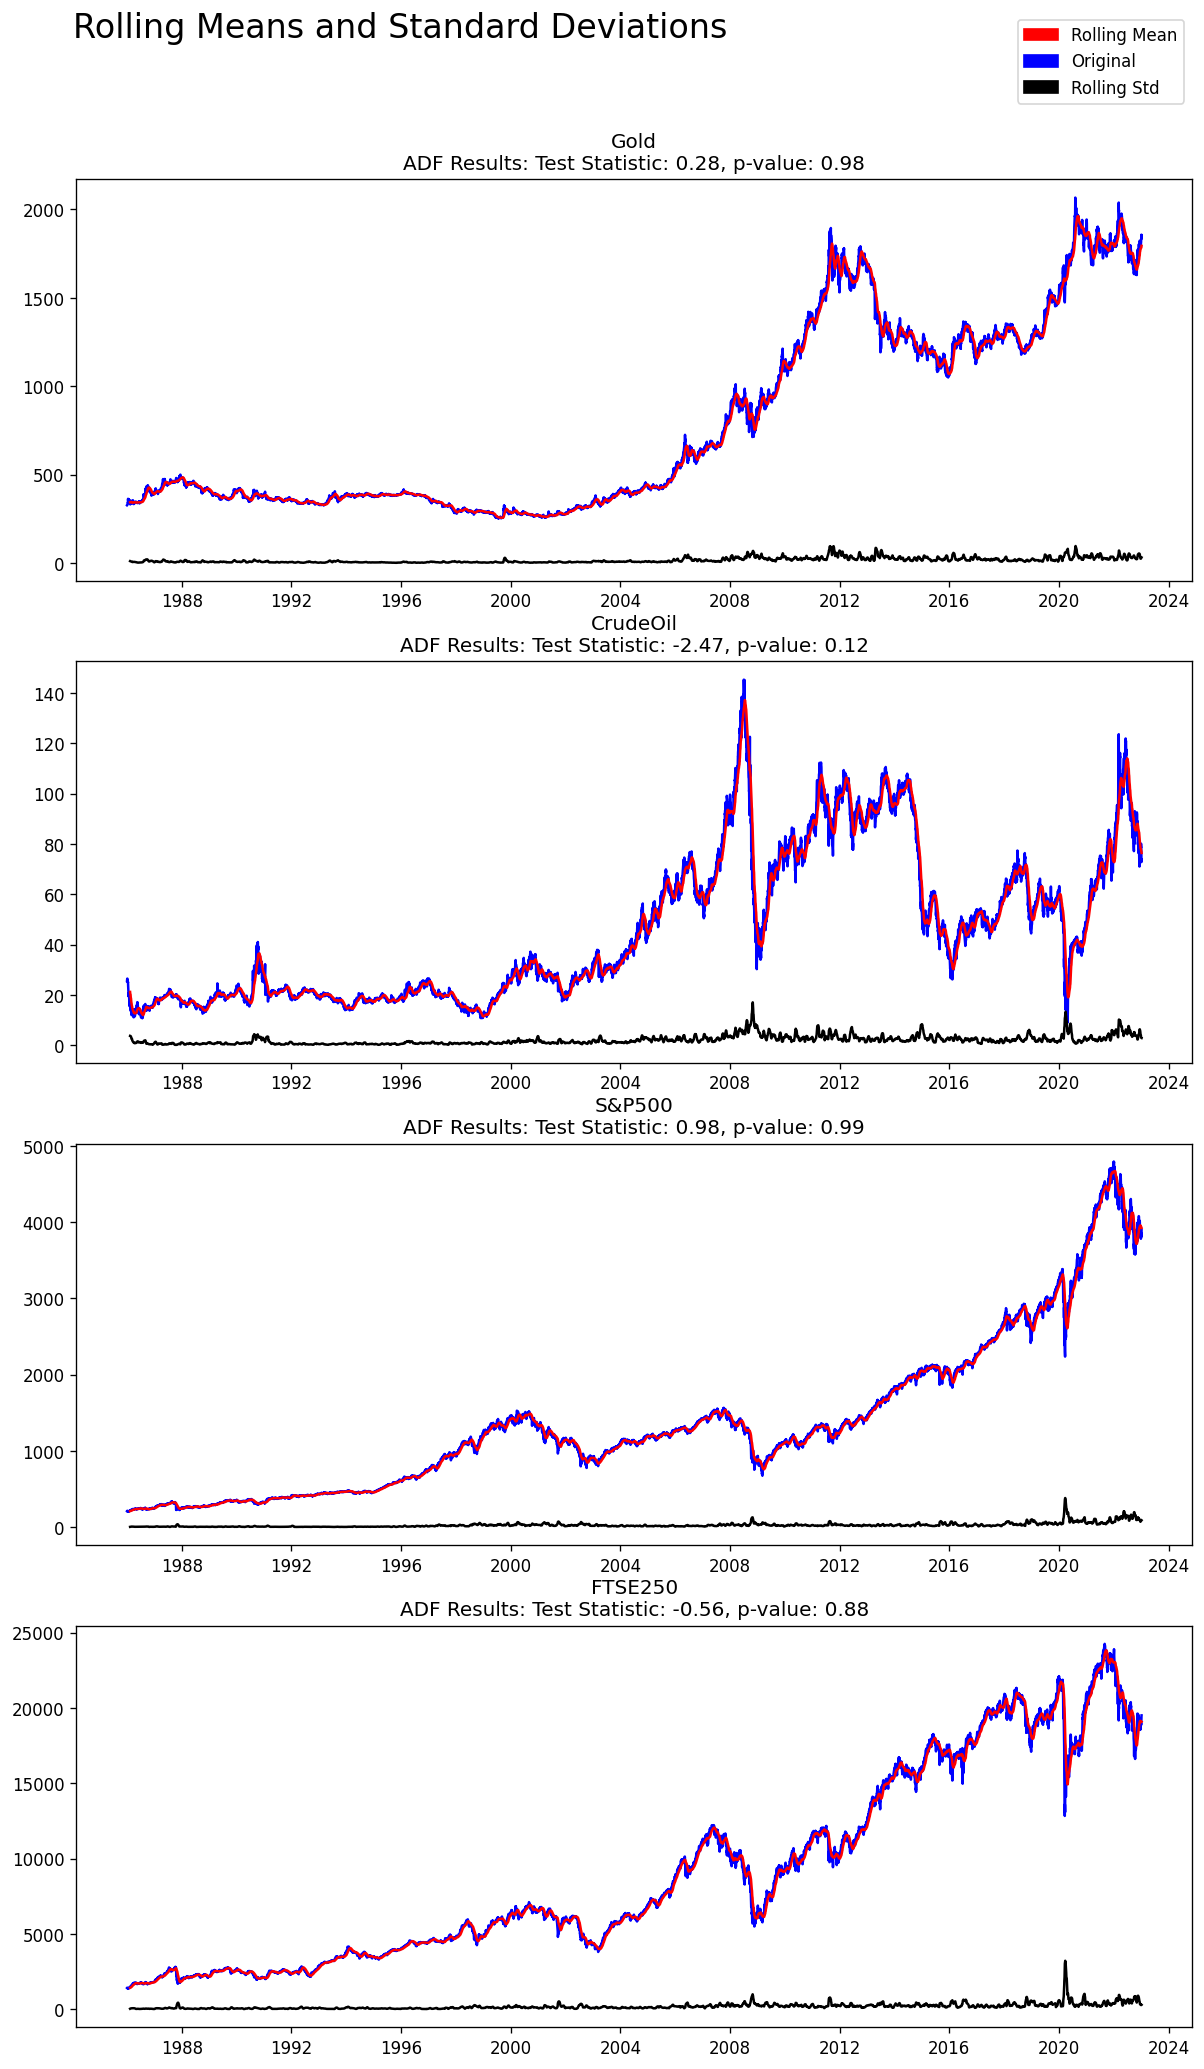

<Figure size 1440x480 with 0 Axes>

In [9]:
plotall(df)

<Figure size 1440x480 with 0 Axes>

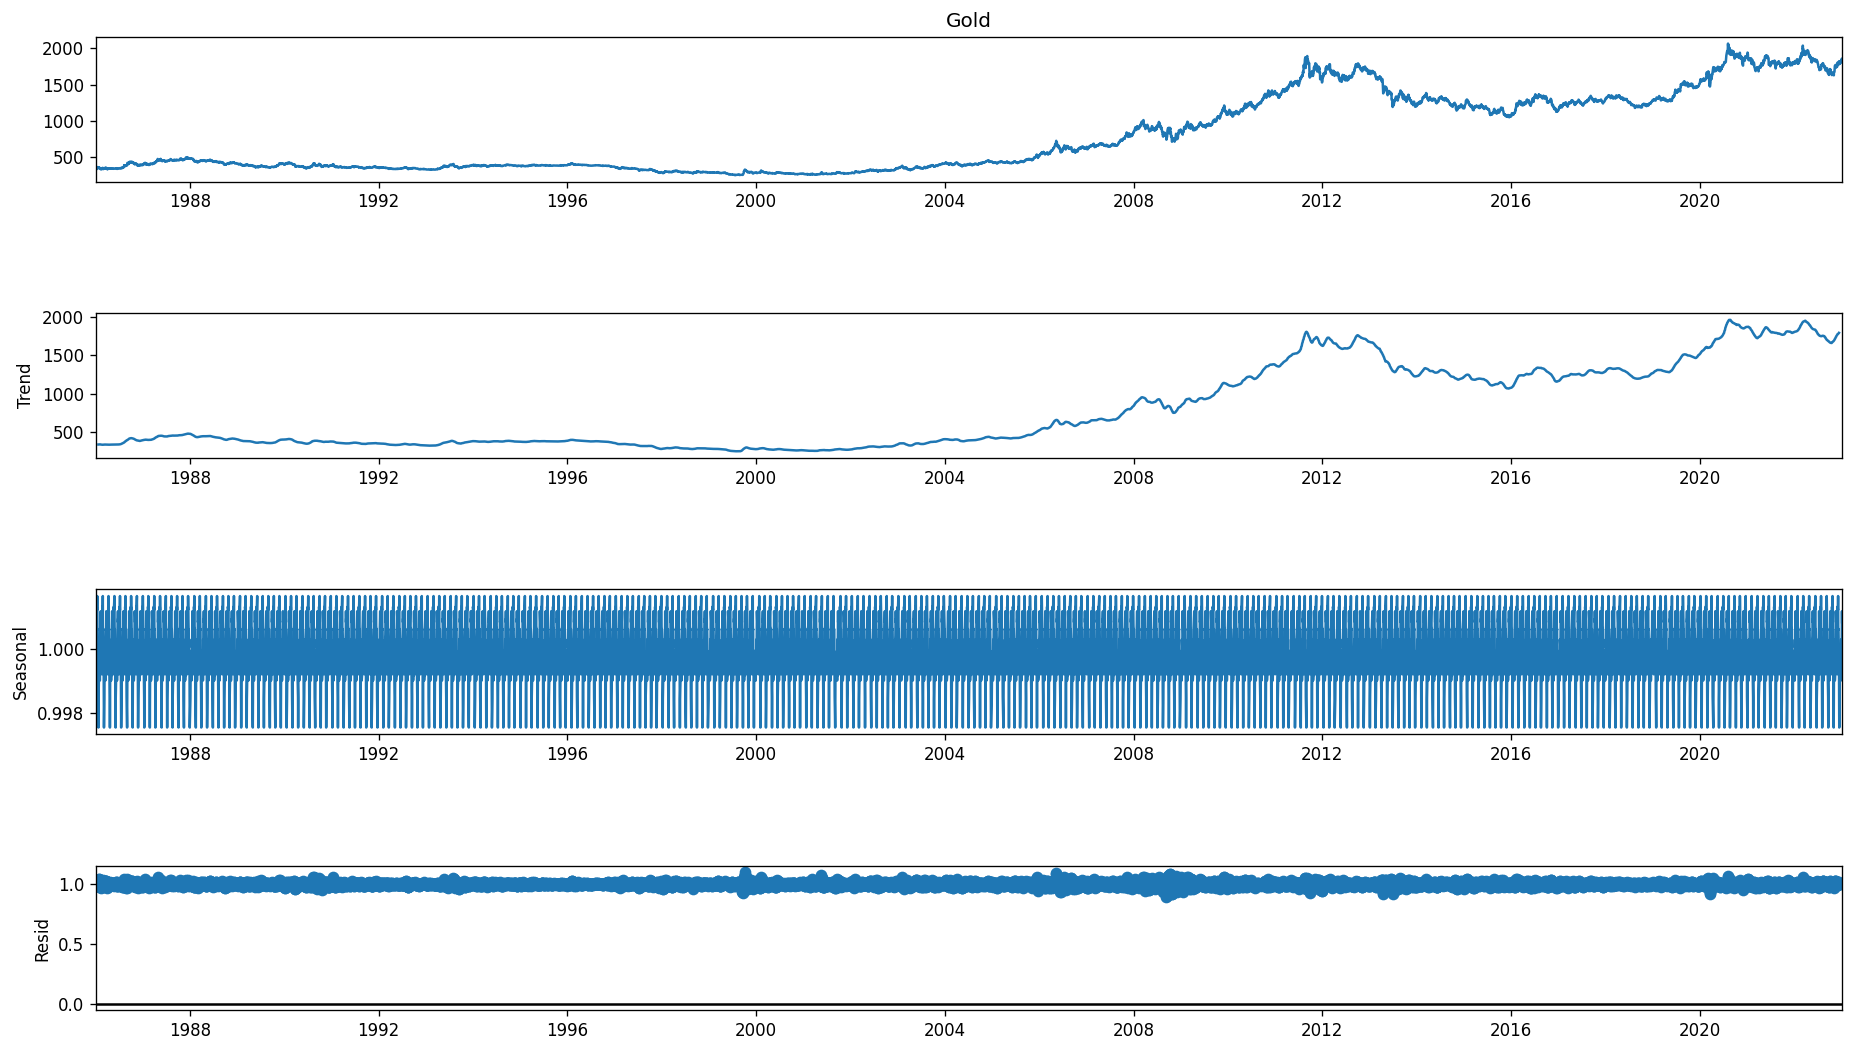

In [10]:
sd_plot  = seasonal_decompose(df['Gold'], model='multiplicative', period=30)
fig = plt.figure()
fig = sd_plot.plot()
fig.set_size_inches(16,10)

Detrending time series 

In [11]:
df_log = np.log(df)

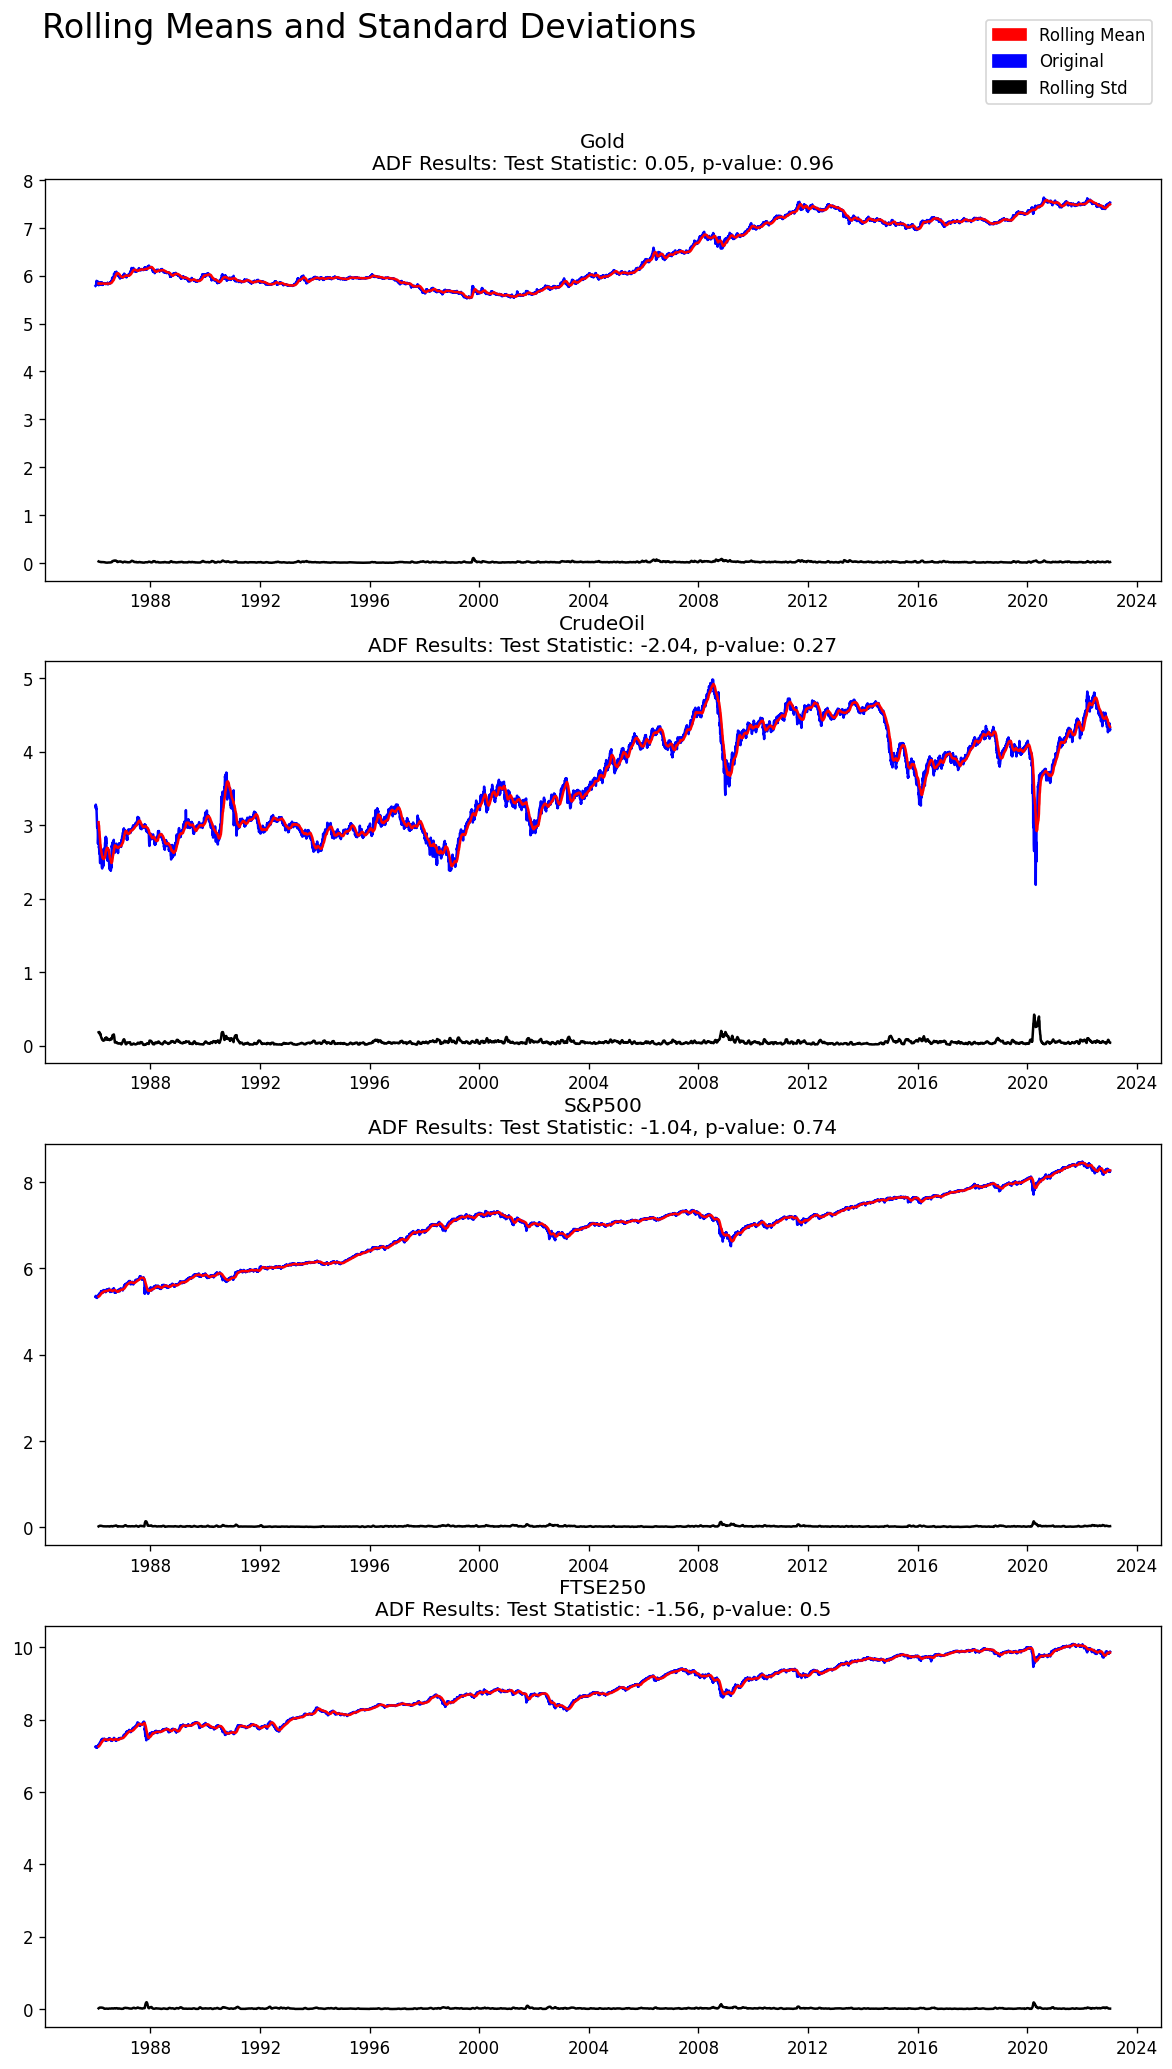

<Figure size 1440x480 with 0 Axes>

In [12]:
plotall(df_log)

Data split

In [13]:
df_log

,Gold,CrudeOil,S&P500,FTSE250
date,,,,
1986-01-02,5.787817,3.241029,5.345153,7.256481
1986-01-03,5.789195,3.258097,5.351289,7.261653
1986-01-06,5.793014,3.278276,5.350198,7.266101
1986-01-07,5.799093,3.252311,5.365041,7.259271
1986-01-08,5.806941,3.253084,5.337394,7.250486
...,...,...,...,...
2022-12-30,7.503152,4.384025,8.253097,9.844427
2023-01-03,7.519286,4.342116,8.249089,9.859240
2023-01-04,7.526879,4.287991,8.256600,9.872568


In [14]:
y = df_log['Gold']
X = df_log.drop('Gold', axis=1)

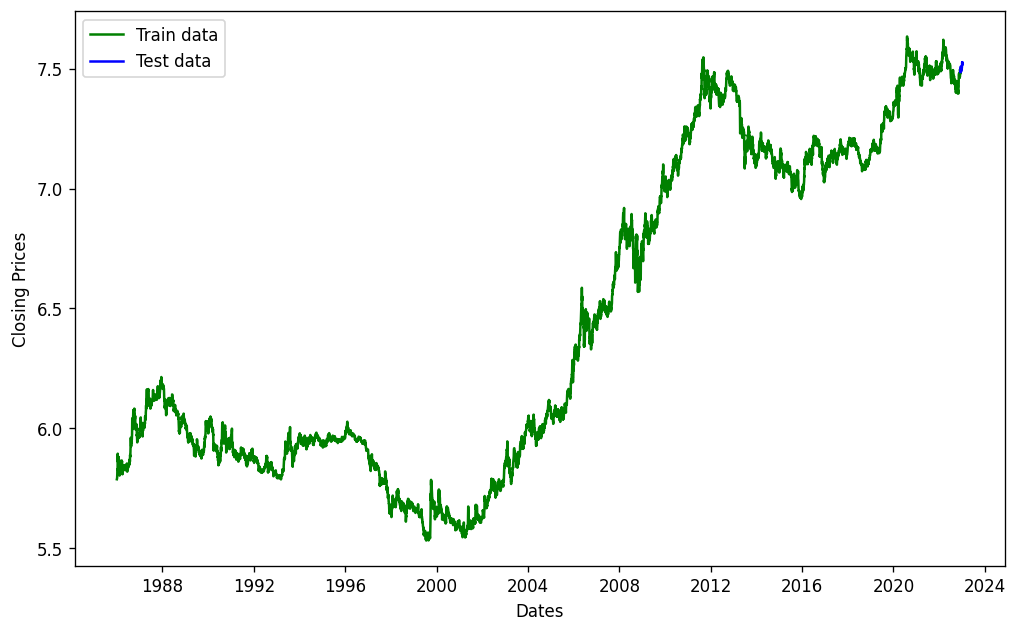

In [15]:
X_train, X_test, y_train, y_test=  X[:-20], X[-20:], y[:-20], y[-20:]
plt.figure(figsize=(10,6))
#plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(y_train, 'green', label='Train data')
plt.plot(y_test, 'blue', label='Test data')
plt.legend()

# Using only gold price

c:\Users\maxim\Documents\GitHub\gold-forecast\venv\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (7) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
c:\Users\maxim\Documents\GitHub\gold-forecast\venv\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-58131.669, Time=1.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-58132.523, Time=0.90 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-58132.552, Time=1.39 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-58130.541, Time=0.58 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-58130.627, Time=2.74 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-58130.757, Time=2.69 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-58128.525, Time=4.28 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-58131.309, Time=0.68 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 14.492 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 9129
Model:               SARIMAX(0, 1, 1)   Log Likelihood               29069.276
Date:                Thu, 13 Apr 2023   AIC                         -58132.552
Time:              

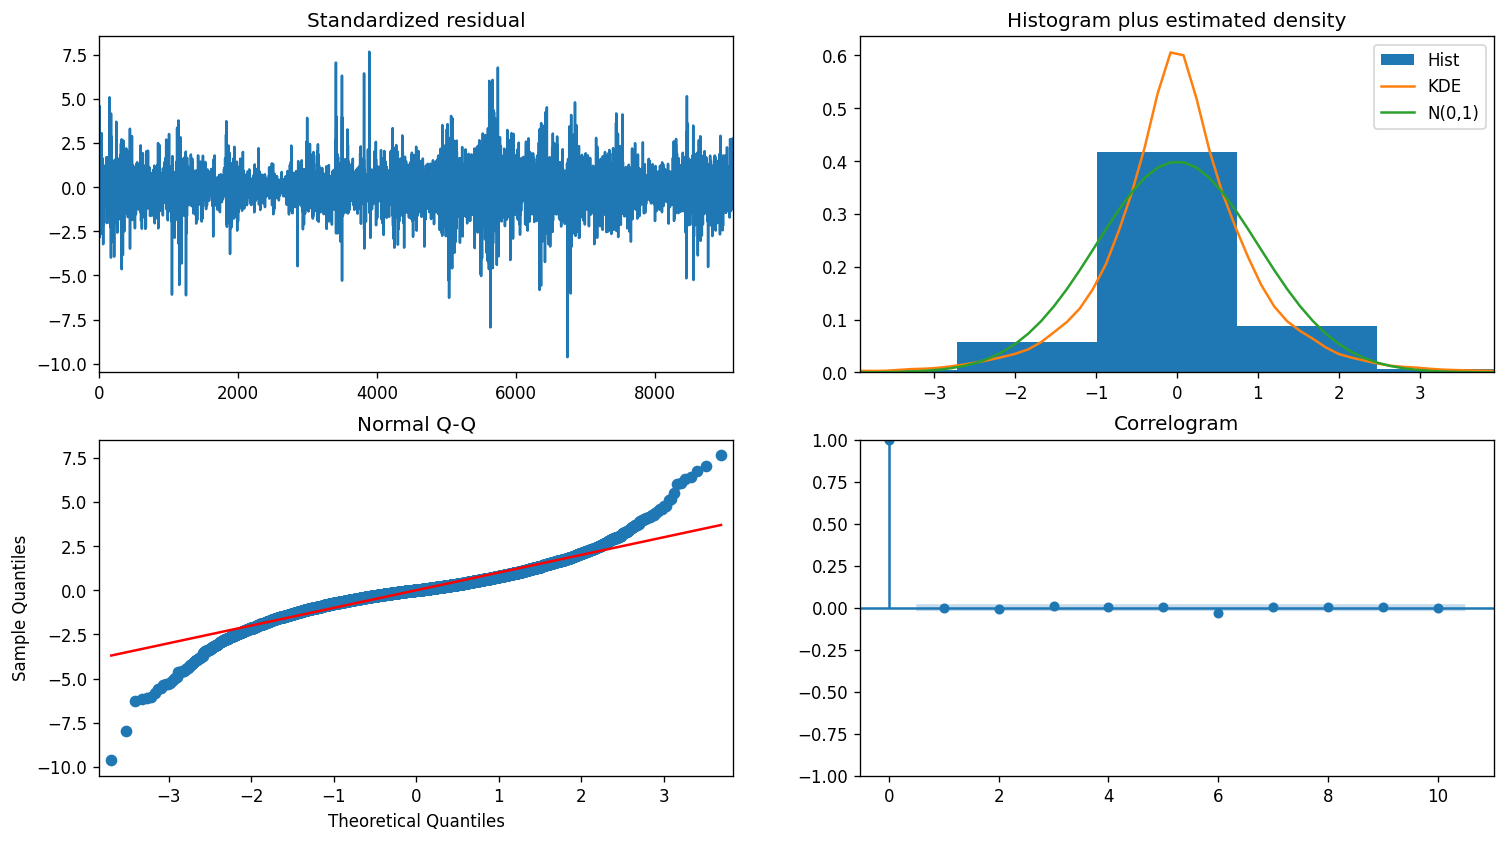

In [16]:
gp_autoARIMA = auto_arima(y_train, 
                      start_p=0, 
                      start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      m=7,             # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True,
                      maxiter=500,
                      scoring='mse',
                      n_jobs=-1)
print(gp_autoARIMA.summary())
gp_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

Fitting  model sugessted above

In [17]:
gp_autoARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 9129
Model:               SARIMAX(0, 1, 1)   Log Likelihood               29069.276
Date:                Thu, 13 Apr 2023   AIC                         -58132.552
Time:                        22:12:11   BIC                         -58111.195
Sample:                             0   HQIC                        -58125.290
                               - 9129                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0002      0.000      1.804      0.071   -1.61e-05       0.000
ma.L1         -0.0177      0.007     -2.430      0.015      -0.032      -0.003
sigma2         0.0001   7.25e-07    138.376      0.000    9.89e-05       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             15952.28
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.53   Skew:                            -0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:
y_hat_gp = gp_autoARIMA.predict(20)

c:\Users\maxim\Documents\GitHub\gold-forecast\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [19]:
y_hat_gp

9129    7.481100
9130    7.481286
9131    7.481472
9132    7.481659
9133    7.481845
9134    7.482031
9135    7.482217
9136    7.482403
9137    7.482589
9138    7.482775
9139    7.482961
9140    7.483147
9141    7.483333
9142    7.483519
9143    7.483705
9144    7.483892
9145    7.484078
9146    7.484264
9147    7.484450
9148    7.484636
dtype: float64

In [20]:
y_hat_gp = pd.DataFrame(y_hat_gp)
y_hat_gp.index = y_test.index
y_hat_gp

,0
date,
2022-12-07,7.481100
2022-12-08,7.481286
2022-12-09,7.481472
2022-12-12,7.481659
2022-12-13,7.481845
2022-12-14,7.482031
2022-12-15,7.482217
2022-12-16,7.482403
2022-12-19,7.482589


In [21]:
inv_ytr = np.exp(y_train)
inv_yt = np.exp(y_test)
y_hgp = np.exp(y_hat_gp)

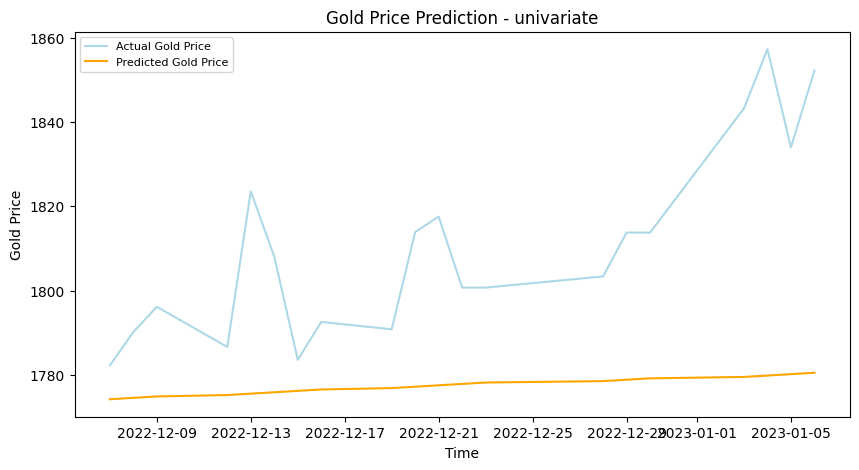

In [22]:
#fc_series = pd.Series(fc, index=test_data.index)
#lower_series = pd.Series(conf[:, 0], index=test_data.index)
#upper_series = pd.Series(conf[:, 1], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
#plt.plot(inv_ytr[inv_ytr.index > '2019-12-31'], label='training data')
plt.plot(inv_yt, color = 'lightblue', label='Actual Gold Price')
plt.plot(y_hgp[0], color = 'orange',label='Predicted Gold Price')
#plt.fill_between(lower_series.index, lower_series, upper_series, 
#                 color='k', alpha=.10)
plt.title('Gold Price Prediction - univariate')
plt.xlabel('Time')
plt.ylabel('Gold Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [23]:
g_mae = mean_absolute_error(inv_yt, y_hgp)
g_mape = mean_absolute_percentage_error(inv_yt, y_hgp)
g_mse = mean_squared_error(inv_yt, y_hgp)
g_rmse = np.sqrt(g_mse)

print(f'MAE: {g_mae}\nMAPE: {g_mape}\nMSE: {g_mse}\nRMSE: {g_rmse}')

MAE: 32.87050366264587
MAPE: 0.018027339653181273
MSE: 1493.9864986741213
RMSE: 38.65212152876115


In [24]:
metric_dict = {'model':[], 'no_observations':[], 'MAE':[], 'MAPE':[], 'MSE':[], 'RMSE':[]}

metric_dict['model'].append('univariate')
metric_dict['no_observations'].append(9149)
metric_dict['MAE'].append(g_mae)
metric_dict['MAPE'].append(g_mape)
metric_dict['MSE'].append(g_mse)
metric_dict['RMSE'].append(g_rmse)

# ARIMA with explanatory variables

c:\Users\maxim\Documents\GitHub\gold-forecast\venv\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (7) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
c:\Users\maxim\Documents\GitHub\gold-forecast\venv\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-58250.609, Time=4.20 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-58255.009, Time=1.75 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-58255.036, Time=5.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-58249.280, Time=5.51 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-58253.076, Time=3.68 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-58253.052, Time=4.29 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-58250.824, Time=11.38 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-58253.524, Time=2.14 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 38.312 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 9129
Model:               SARIMAX(0, 1, 1)   Log Likelihood               29133.518
Date:                Thu, 13 Apr 2023   AIC                         -58255.036
Time:             

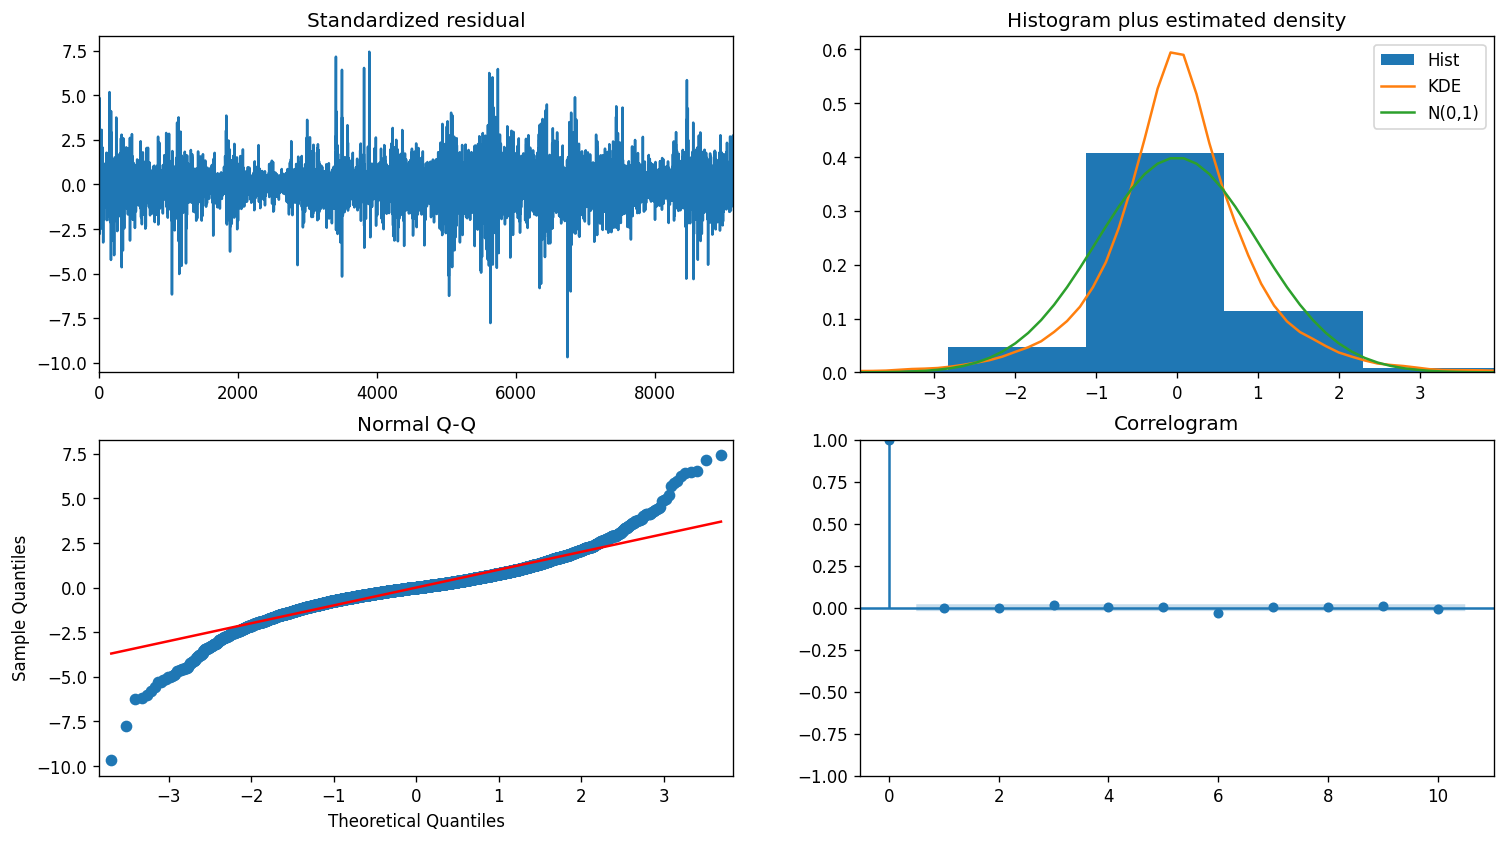

In [25]:
mvgp_autoARIMA = auto_arima(y=y_train, X=X_train, 
                      start_p=0, 
                      start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      m=7,             # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True,
                      maxiter=500,
                      scoring='mse',
                      n_jobs=-1)
print(mvgp_autoARIMA.summary())
mvgp_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [26]:
mvgp_autoARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 9129
Model:               SARIMAX(0, 1, 1)   Log Likelihood               29133.518
Date:                Thu, 13 Apr 2023   AIC                         -58255.036
Time:                        22:12:52   BIC                         -58212.322
Sample:                             0   HQIC                        -58240.512
                               - 9129                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0002      0.000      1.876      0.061   -8.52e-06       0.000
CrudeOil       0.0395      0.002     16.584      0.000       0.035       0.044
S&P500        -0.0394      0.006     -6.870      0.000      -0.051      -0.028
FTSE250        0.0124      0.007      1.741      0.082      -0.002       0.026
ma.L1         -0.0265      0.007     -3.580      0.000      -0.041      -0.012
sigma2      9.889e-05   7.24e-07    136.613      0.000    9.75e-05       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             15304.37
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.56   Skew:                            -0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
y_hat_mv = mvgp_autoARIMA.predict(20, X_test)

c:\Users\maxim\Documents\GitHub\gold-forecast\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [28]:
y_hat_mv

9129    7.479828
9130    7.479306
9131    7.479710
9132    7.480327
9133    7.481728
9134    7.483008
9135    7.483453
9136    7.482988
9137    7.484031
9138    7.484568
9139    7.485544
9140    7.485993
9141    7.486948
9142    7.487473
9143    7.486825
9144    7.487884
9145    7.486762
9146    7.484684
9147    7.485810
9148    7.485224
dtype: float64

In [29]:
y_hat_mv = pd.DataFrame(y_hat_mv)
y_hat_mv.index = y_test.index
y_hat_mv

,0
date,
2022-12-07,7.479828
2022-12-08,7.479306
2022-12-09,7.479710
2022-12-12,7.480327
2022-12-13,7.481728
2022-12-14,7.483008
2022-12-15,7.483453
2022-12-16,7.482988
2022-12-19,7.484031


In [30]:
inv_ytr = np.exp(y_train)
inv_yt = np.exp(y_test)
inv_yhmv = np.exp(y_hat_mv)

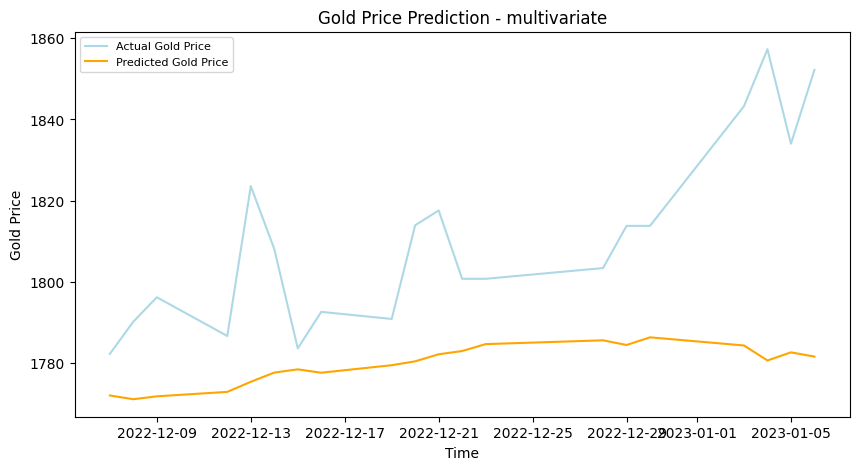

In [31]:
plt.figure(figsize=(10,5), dpi=100)
#plt.plot(inv_ytr[inv_ytr.index > '2019-12-31'], label='training data')
plt.plot(inv_yt, color = 'lightblue', label='Actual Gold Price')
plt.plot(inv_yhmv[0], color = 'orange',label='Predicted Gold Price')
#plt.fill_between(lower_series.index, lower_series, upper_series, 
#                 color='k', alpha=.10)
plt.title('Gold Price Prediction - multivariate')
plt.xlabel('Time')
plt.ylabel('Gold Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [32]:
g_mae = mean_absolute_error(inv_yt, inv_yhmv)
g_mape = mean_absolute_percentage_error(inv_yt, inv_yhmv)
g_mse = mean_squared_error(inv_yt, inv_yhmv)
g_rmse = np.sqrt(g_mse)

print(f'MAE: {g_mae}\nMAPE: {g_mape}\nMSE: {g_mse}\nRMSE: {g_rmse}')

MAE: 30.665931741813438
MAPE: 0.016814403946094927
MSE: 1339.9386566265634
RMSE: 36.60517253922679


In [33]:
metric_dict['model'].append('multivariate')
metric_dict['no_observations'].append(9149)
metric_dict['MAE'].append(g_mae)
metric_dict['MAPE'].append(g_mape)
metric_dict['MSE'].append(g_mse)
metric_dict['RMSE'].append(g_rmse)

---
# ARIMA with less data
Since econometric approaches are more suitable than deep learning with lower amounts of data, let's try reducing the dataset size to most recent year and see if the results maybe improve.

In [34]:
df_log.tail()

,Gold,CrudeOil,S&P500,FTSE250
date,,,,
2022-12-30,7.503152,4.384025,8.253097,9.844427
2023-01-03,7.519286,4.342116,8.249089,9.859240
2023-01-04,7.526879,4.287991,8.256600,9.872568
2023-01-05,7.514255,4.298781,8.244886,9.876293
2023-01-06,7.524129,4.300952,8.267469,9.878412


In [35]:
df_log_cut = df_log[df_log.index>'2022-01-05']
df_log_cut

,Gold,CrudeOil,S&P500,FTSE250
date,,,,
2022-01-06,7.489608,4.375380,8.454477,10.061214
2022-01-07,7.491422,4.369448,8.450419,10.058491
2022-01-10,7.492315,4.358118,8.448976,10.043328
2022-01-11,7.499313,4.396546,8.458095,10.044474
2022-01-12,7.507361,4.412919,8.460909,10.045298
...,...,...,...,...
2022-12-30,7.503152,4.384025,8.253097,9.844427
2023-01-03,7.519286,4.342116,8.249089,9.859240
2023-01-04,7.526879,4.287991,8.256600,9.872568


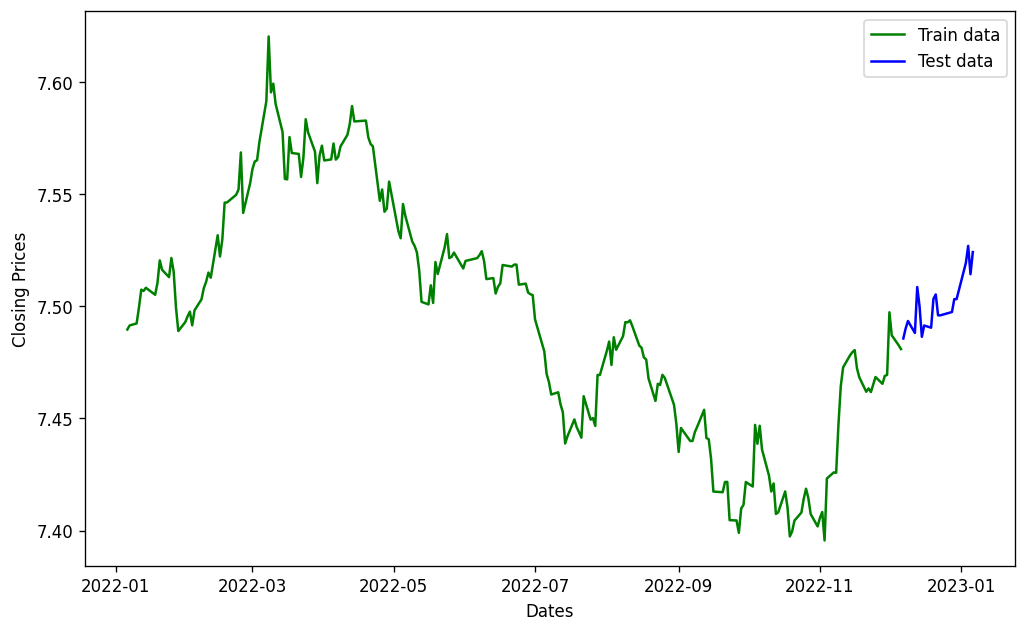

In [36]:
y = df_log_cut['Gold']
X = df_log_cut.drop('Gold', axis=1)

X_train, X_test, y_train, y_test=  X[:-20], X[-20:], y[:-20], y[-20:]
plt.figure(figsize=(10,6))
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(y_train, 'green', label='Train data')
plt.plot(y_test, 'blue', label='Test data')
plt.legend()

## Only Gold price

c:\Users\maxim\Documents\GitHub\gold-forecast\venv\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (7) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
c:\Users\maxim\Documents\GitHub\gold-forecast\venv\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1454.443, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1453.533, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1453.424, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1456.439, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1451.660, Time=0.50 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.239 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  225
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 729.220
Date:                Thu, 13 Apr 2023   AIC                          -1456.439
Time:                        22:12:55   BIC                          -1453.028
Sample:                             0   HQIC                         -1455.062
                                - 225                                  

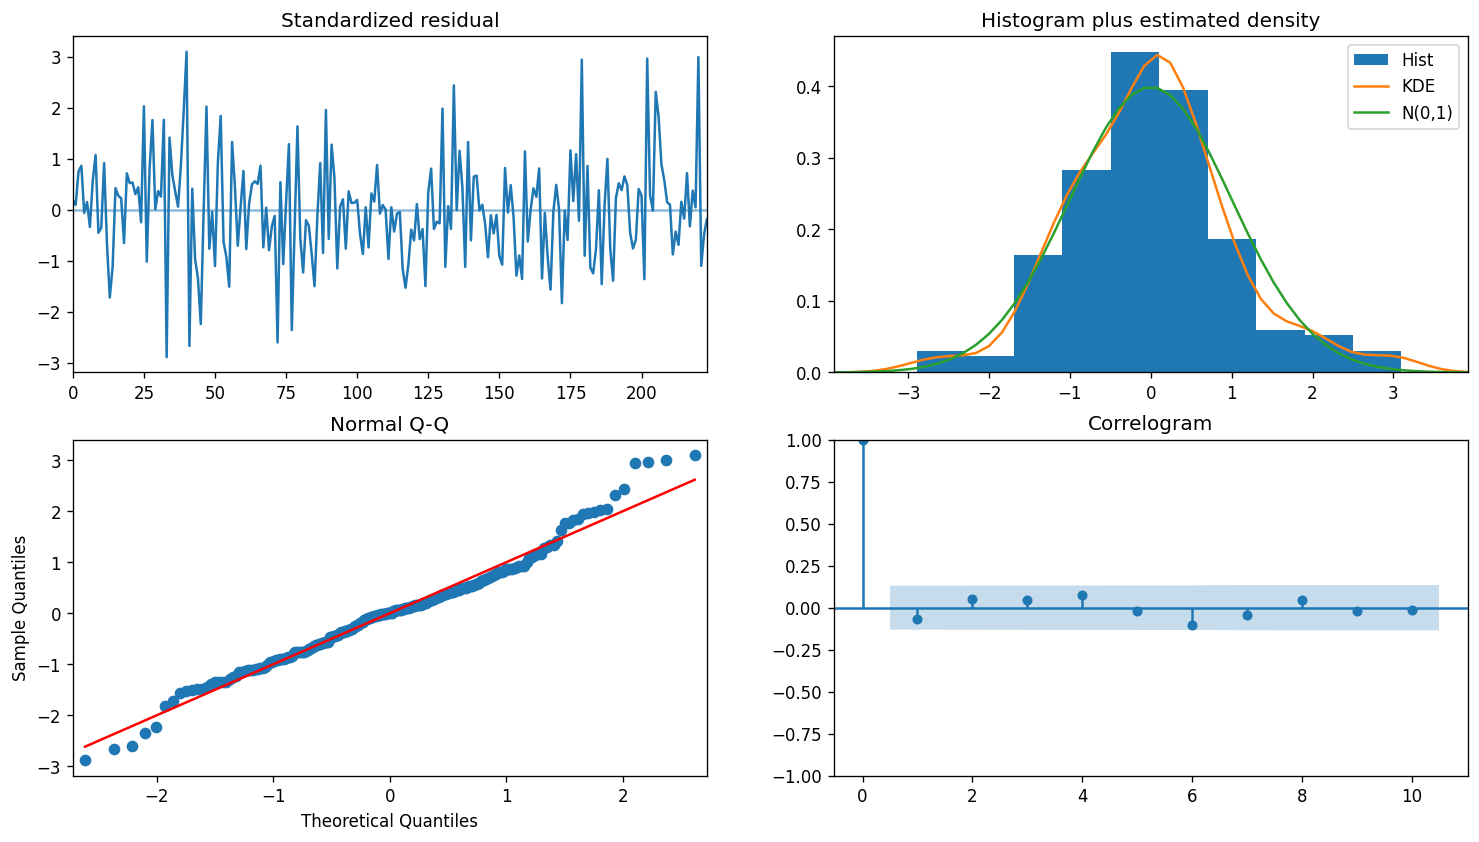

In [37]:
gpcut_autoARIMA = auto_arima(y_train, 
                      start_p=0, 
                      start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      m=7,             # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True,
                      maxiter=500,
                      scoring='mse',
                      n_jobs=-1)
print(gpcut_autoARIMA.summary())
gpcut_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [38]:
gpcut_autoARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  225
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 729.220
Date:                Thu, 13 Apr 2023   AIC                          -1456.439
Time:                        22:12:56   BIC                          -1453.028
Sample:                             0   HQIC                         -1455.062
                                - 225                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      8.698e-05   6.78e-06     12.820      0.000    7.37e-05       0.000
===================================================================================
Ljung-Box (L1) (Q):                   1.11   Jarque-Bera (JB):                11.80
Prob(Q):                              0.29   Prob(JB):                         0.00
Heteroskedasticity (H):               0.84   Skew:                             0.31
Prob(H) (two-sided):                  0.44   Kurtosis:                         3.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [39]:
y_hat_gpc = gpcut_autoARIMA.predict(20)

c:\Users\maxim\Documents\GitHub\gold-forecast\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [40]:
y_hat_gpc = pd.DataFrame(y_hat_gpc)
y_hat_gpc.index = y_test.index
y_hat_gpc

,0
date,
2022-12-07,7.480879
2022-12-08,7.480879
2022-12-09,7.480879
2022-12-12,7.480879
2022-12-13,7.480879
2022-12-14,7.480879
2022-12-15,7.480879
2022-12-16,7.480879
2022-12-19,7.480879


In [41]:
inv_ytr = np.exp(y_train)
inv_yt = np.exp(y_test)
inv_yhgpc = np.exp(y_hat_gpc)

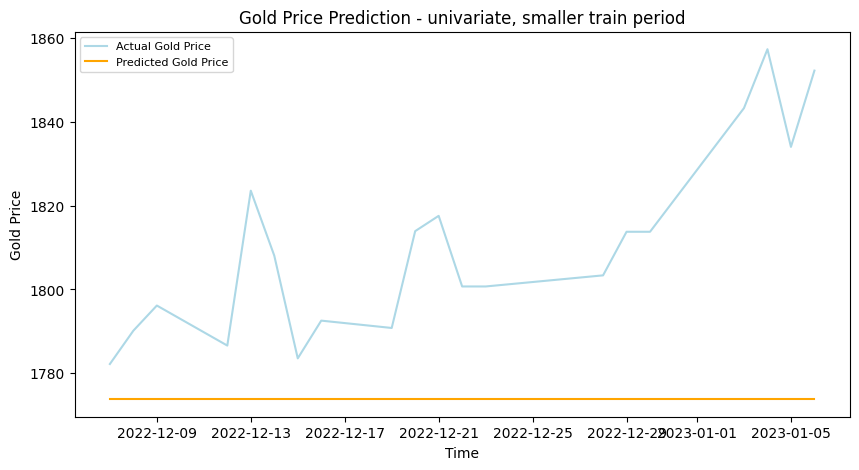

In [42]:
plt.figure(figsize=(10,5), dpi=100)
#plt.plot(inv_ytr[inv_ytr.index > '2019-12-31'], label='training data')
plt.plot(inv_yt, color = 'lightblue', label='Actual Gold Price')
plt.plot(inv_yhgpc[0], color = 'orange',label='Predicted Gold Price')
#plt.fill_between(lower_series.index, lower_series, upper_series, 
#                 color='k', alpha=.10)
plt.title('Gold Price Prediction - univariate, smaller train period')
plt.xlabel('Time')
plt.ylabel('Gold Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [43]:
g_mae = mean_absolute_error(inv_yt, inv_yhgpc)
g_mape = mean_absolute_percentage_error(inv_yt, inv_yhgpc)
g_mse = mean_squared_error(inv_yt, inv_yhgpc)
g_rmse = np.sqrt(g_mse)

print(f'MAE: {g_mae}\nMAPE: {g_mape}\nMSE: {g_mse}\nRMSE: {g_rmse}')

MAE: 36.402500000000884
MAPE: 0.019969041933883068
MSE: 1799.2823750000648
RMSE: 42.417948736355285


In [44]:
metric_dict['model'].append('univariate')
metric_dict['no_observations'].append(245)
metric_dict['MAE'].append(g_mae)
metric_dict['MAPE'].append(g_mape)
metric_dict['MSE'].append(g_mse)
metric_dict['RMSE'].append(g_rmse)

## With explanatory variables

Performing stepwise search to minimize aic


c:\Users\maxim\Documents\GitHub\gold-forecast\venv\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (7) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
c:\Users\maxim\Documents\GitHub\gold-forecast\venv\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1476.424, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1476.791, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1476.381, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1478.421, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1475.822, Time=0.57 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.334 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  225
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 743.210
Date:                Thu, 13 Apr 2023   AIC                          -1478.421
Time:                        22:12:58   BIC                          -1464.774
Sample:                             0   HQIC                         -1472.912
                                - 225                                         
Covariance Type:                  o

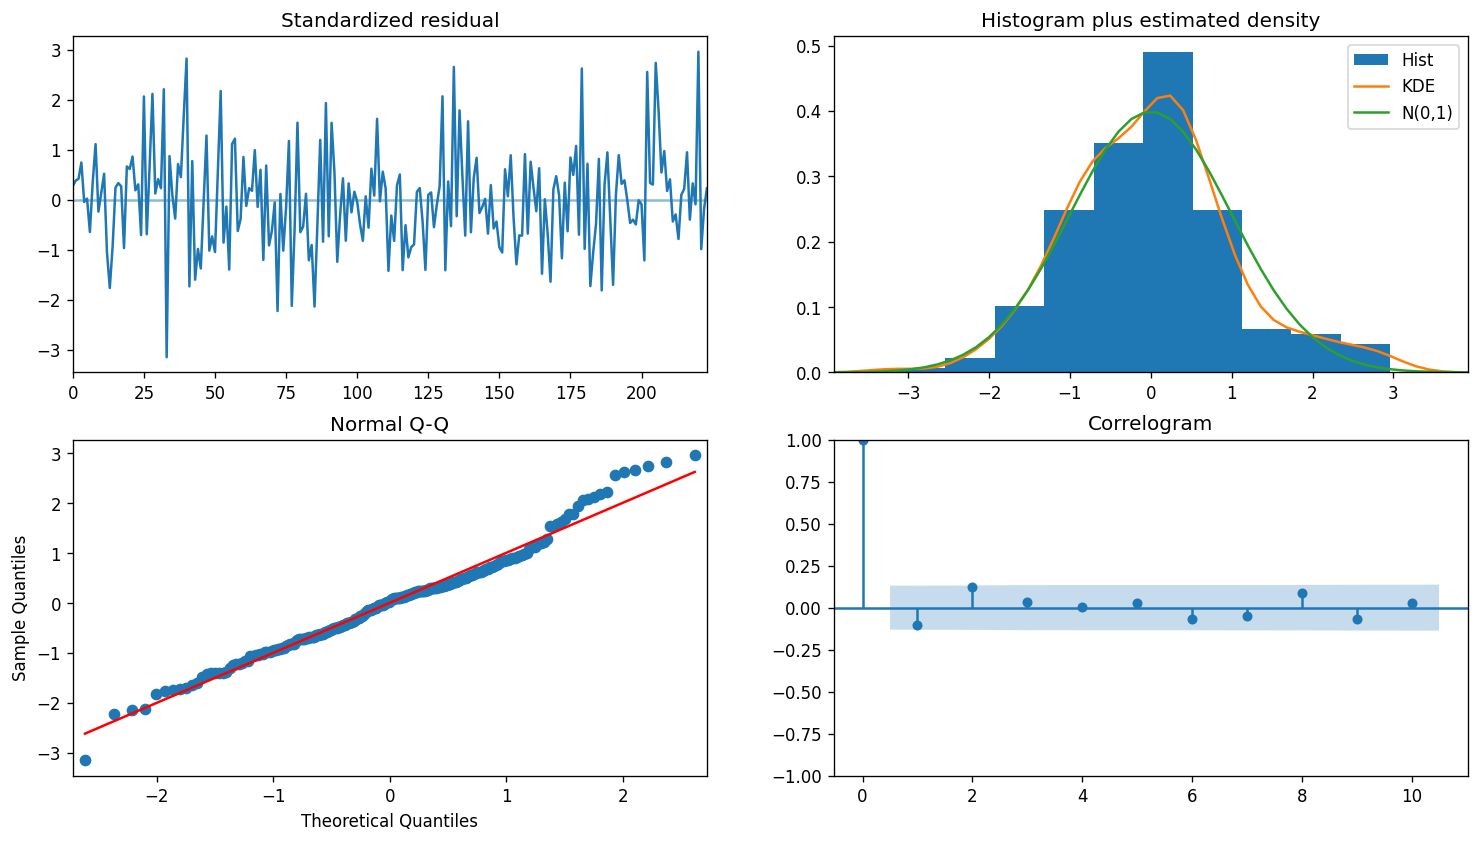

In [45]:
mvgpcut_autoARIMA = auto_arima(y=y_train, X=X_train, 
                      start_p=0, 
                      start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      m=7,             # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True,
                      maxiter=500,
                      scoring='mse',
                      n_jobs=-1)
print(mvgpcut_autoARIMA.summary())
mvgpcut_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [46]:
mvgpcut_autoARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  225
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 743.210
Date:                Thu, 13 Apr 2023   AIC                          -1478.421
Time:                        22:12:59   BIC                          -1464.774
Sample:                             0   HQIC                         -1472.912
                                - 225                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
CrudeOil       0.0974      0.018      5.414      0.000       0.062       0.133
S&P500        -0.0567      0.041     -1.390      0.165      -0.137       0.023
FTSE250        0.0960      0.045      2.135      0.033       0.008       0.184
sigma2      7.676e-05   6.37e-06     12.050      0.000    6.43e-05    8.92e-05
===================================================================================
Ljung-Box (L1) (Q):                   2.40   Jarque-Bera (JB):                 8.70
Prob(Q):                              0.12   Prob(JB):                         0.01
Heteroskedasticity (H):               0.87   Skew:                             0.35
Prob(H) (two-sided):                  0.55   Kurtosis:                         3.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [47]:
y_hat_mvc = mvgpcut_autoARIMA.predict(20,X_test)

c:\Users\maxim\Documents\GitHub\gold-forecast\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [48]:
y_hat_mvc = pd.DataFrame(y_hat_mvc)
y_hat_mvc.index = y_test.index
y_hat_mvc

,0
date,
2022-12-07,7.477091
2022-12-08,7.475267
2022-12-09,7.475811
2022-12-12,7.477100
2022-12-13,7.481294
2022-12-14,7.483565
2022-12-15,7.482676
2022-12-16,7.479541
2022-12-19,7.481488


In [49]:
inv_ytr = np.exp(y_train)
inv_yt = np.exp(y_test)
inv_yhmvc = np.exp(y_hat_mvc)

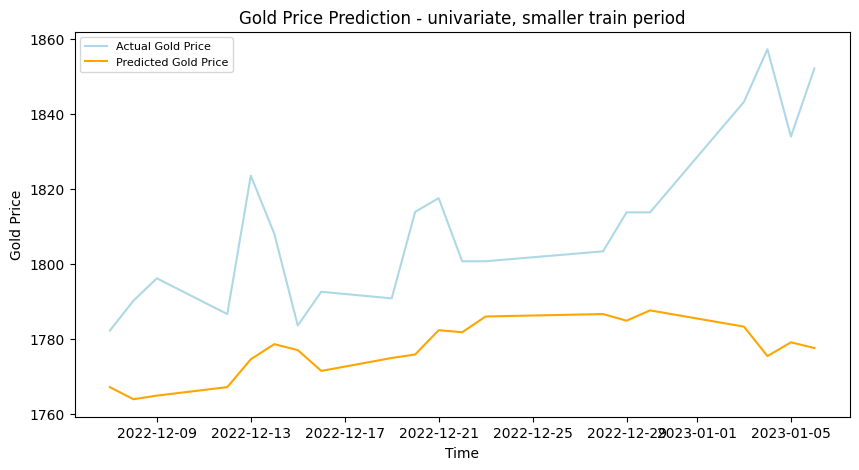

In [50]:
plt.figure(figsize=(10,5), dpi=100)
#plt.plot(inv_ytr[inv_ytr.index > '2019-12-31'], label='training data')
plt.plot(inv_yt, color = 'lightblue', label='Actual Gold Price')
plt.plot(inv_yhmvc[0], color = 'orange',label='Predicted Gold Price')
#plt.fill_between(lower_series.index, lower_series, upper_series, 
#                 color='k', alpha=.10)
plt.title('Gold Price Prediction - univariate, smaller train period')
plt.xlabel('Time')
plt.ylabel('Gold Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [51]:
g_mae = mean_absolute_error(inv_yt, inv_yhmvc)
g_mape = mean_absolute_percentage_error(inv_yt, inv_yhmvc)
g_mse = mean_squared_error(inv_yt, inv_yhmvc)
g_rmse = np.sqrt(g_mse)

print(f'MAE: {g_mae}\nMAPE: {g_mape}\nMSE: {g_mse}\nRMSE: {g_rmse}')

MAE: 33.23255615780549
MAPE: 0.018235390728133204
MSE: 1513.3328263661804
RMSE: 38.901578713031434


In [52]:
metric_dict['model'].append('multivariate')
metric_dict['no_observations'].append(245)
metric_dict['MAE'].append(g_mae)
metric_dict['MAPE'].append(g_mape)
metric_dict['MSE'].append(g_mse)
metric_dict['RMSE'].append(g_rmse)

In [53]:
metrics_df = pd.DataFrame(metric_dict)
metrics_df['MAE'], metrics_df['MAPE'], metrics_df['MSE'], metrics_df['RMSE'] = round(metrics_df['MAE'],2), round(metrics_df['MAPE'],2), round(metrics_df['MSE'],2), round(metrics_df['RMSE'],2)

metrics_df

,model,no_observations,MAE,MAPE,MSE,RMSE
0,univariate,9149,32.87,0.02,1493.99,38.65
1,multivariate,9149,30.67,0.02,1339.94,36.61
2,univariate,245,36.40,0.02,1799.28,42.42
3,multivariate,245,33.23,0.02,1513.33,38.90
